In [1]:
import numpy as np
import torch
import torch.nn as nn
#import pandas as pd
from skimage import io, transform
import torch.autograd as ag
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
from scipy import signal
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable
import time
from functools import reduce
import math

torch.set_printoptions(precision=6)


0 torch.Size([7, 1, 64, 64])
1 torch.Size([7, 1, 64, 64])
2 torch.Size([7, 1, 64, 64])


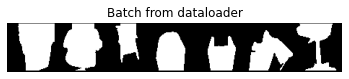

"\ntransform = transforms.Compose([\n    transforms.Pad(12, padding_mode='reflect'),\n    transforms.ToTensor()])\n\ntrainset = torchvision.datasets.Flickr8k(root='./data/flickr', ann_file = './data/flickr/file.csv', transform=transform)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)\n"

In [2]:
class ImageDataset(Dataset):

    def __init__(self, depthmap_dir, mask_dir, segmentation_dir, transform=None):
        """
        Args:
            depthmap_dir (string): Directory with all the depthmaps.
            mask_dir (string): Directory with all the masks.
            segmentation_dir (string): Directory with all the segmentation of the depthmaps.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.depthmap_dir = depthmap_dir
        self.mask_dir = mask_dir
        self.segmentation_dir = segmentation_dir
        self.transform = transform

    def __len__(self):
        path, dirs, files = next(os.walk(self.depthmap_dir))
        file_count = len(files)
        return file_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path_d, dirs_d, files_d = next(os.walk(self.depthmap_dir))
        img_d_name = os.path.join(self.depthmap_dir, files_d[idx])
        image_d = io.imread(img_d_name)
        
        path_m, dirs_m, files_m = next(os.walk(self.mask_dir))
        img_m_name = os.path.join(self.mask_dir, files_m[idx])
        image_m = io.imread(img_m_name)
        
        path_s, dirs_s, files_s = next(os.walk(self.segmentation_dir))
        img_s_name = os.path.join(self.segmentation_dir, files_s[idx])
        image_s = io.imread(img_s_name)

        if self.transform:
            image_d = self.transform(image_d)
            image_m = self.transform(image_m)
            image_s = self.transform(image_s)

        return image_d, image_m, image_s


class RandomCrop(object):
    """Crop randomly the image

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        if h!= new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top = 0
        if w!= new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
     
        image = image[top: top + new_h,
                      left: left + new_w]
        
        image = np.expand_dims(image, axis=2)

        return image
    
    
class Downsample(object):
    """Downsample the image

    Args:
        downsampling_factor (int or tuple): Desired downsampling factor for rows and columns.
        If the downsampling factor is an int, then both rows and columns are sampled by the same factor
    """

    def __init__(self, downsampling_factor):
        assert isinstance(downsampling_factor, (int, tuple))
        if isinstance(downsampling_factor, int):
            self.downsampling_factor = (downsampling_factor, downsampling_factor)
        else:
            assert len(downsampling_factor) == 2
            self.downsampling_factor = downsampling_factor

    def __call__(self, image):
        
        down_fact_h, down_fact_w = self.downsampling_factor
        image = image[::down_fact_h,
                      ::down_fact_w]

        return image
    
    
class ConvertDepthToColor(object):
    """ convert a 1xmxn 16-bits depthmap to a 2xmxn 8-bits colormap

    """

    def __call__(self, image):
        if len(image.shape[:]) <3:
            image = np.expand_dims(image, axis=2)
            
        h, w = image.shape[:2]
        image_r_color= np.zeros((h,w,1), dtype=int)
        image_g_color= np.zeros((h,w,1), dtype=int)
        image_g_color[(image > 2**8 - 1)] = image[(image > 2**8 - 1)] >> 8
        image_r_color = image - (image_g_color <<8)

        return np.concatenate((image_r_color, image_g_color), axis=2)
    

class ToTensor(object):
    """Convert ndarrays in images to Tensors."""

    def __call__(self, images):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        images = images.transpose((2, 0, 1))
        images = images.astype(float)
        return torch.from_numpy(images)
    

    
class ConvertColorToDepth(object):
    """ convert a 2xmxn 8-bits colormap to a 1xmxn 16-bits depthmap

    """

    def __call__(self, color_image):
            
        depth_image = color_image[:, 0, :, :]
        depth_image += color_image[:, 1, :, :] << 8

        return depth_image

    
def show_image_batch(images_batch):
    """Show image for a batch of samples."""
    if images_batch.size(1) == 1:
        images_batch_normed = images_batch/torch.max(images_batch)
        grid = utils.make_grid(images_batch_normed)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')
    else:
        print(images_batch.size())
        images_b_batch = torch.zeros(images_batch.size(0), 1, images_batch.size(2) , images_batch.size(3))
        images_color_batch = torch.cat((images_batch, images_b_batch), 1) 
        print(images_color_batch.size())
        grid = utils.make_grid(images_color_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')
    
    
    
    
# Load training dataset

#mirror_padding_transform = transforms.Compose([transforms.ToPILImage(), transforms.Pad(padding=12, padding_mode='reflect'), transforms.ToTensor()])
    # the  datasets contain depthmaps (first composant), masks (second composant) and segmentations (third composant)
transformed_datasets = ImageDataset(depthmap_dir='C:/Users/Flora/autoencoder/training/dilated', 
                                mask_dir='C:/Users/Flora/autoencoder/training/mask',
                                segmentation_dir='C:/Users/Flora/autoencoder/training/segmentation_roipoly',
                                transform=transforms.Compose([RandomCrop((384, 640)), Downsample(( 3*2, 5*2)), ToTensor()])
                                 )
dataloader = DataLoader(transformed_datasets, batch_size=7, shuffle=True, num_workers=0)

for i_batch, batch_images in enumerate(dataloader):
    print(i_batch, batch_images[2].size())

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_image_batch(batch_images[2])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

"""
transform = transforms.Compose([
    transforms.Pad(12, padding_mode='reflect'),
    transforms.ToTensor()])

trainset = torchvision.datasets.Flickr8k(root='./data/flickr', ann_file = './data/flickr/file.csv', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
"""

In [3]:
#Define additionnnal functions
def periodic_shuffling(T, C):
    T_copy = T.clone()
    batch_size = T.size()[0]
    H = T.size()[2]
    W = T.size()[3]
    T = T.view(batch_size, C, H*2, W*2)
    """
    for k in range(C):
        for i in range(2*H):
            for j in range(2*W):
                T[:, k, i, j] = T_copy[:, C*((j&1)<<1)+C*(i&1)+k, i>>1, j>>1]
    """
                
    T[:, :, ::2, ::2] = T_copy[:, 0:C, :, :]
    T[:, :, 1::2, ::2] = T_copy[:, C:2*C, :, :]
    T[:, :, ::2, 1::2] = T_copy[:, 2*C:3*C, :, :]
    T[:, :, 1::2, 1::2] = T_copy[:, 3*C:4*C, :, :]

    return T
    
    
def mirror_padding(x, padding_size):
    up_line = x[:, :, 0:padding_size, :].flip(2)
    left_col = x[:, :, :, 0:padding_size].flip(3)
    right_col = x[:, :, :, -padding_size:].flip(3)
    bottom_line = x[:, :, -padding_size:, :].flip(2)
    left_up_corner = left_col[:, :, 0:padding_size, :].flip(2)
    right_up_corner = right_col[:, :, 0:padding_size, :].flip(2)
    left_bottom_corner = left_col[:, :, -padding_size:, :].flip(2)
    right_bottom_corner = right_col[:, :, -padding_size:, :].flip(2)

    x_mirror_pad = torch.cat((torch.cat((left_up_corner, up_line, right_up_corner), 3), torch.cat((left_col, x, right_col), 3), torch.cat((left_bottom_corner, bottom_line, right_bottom_corner), 3)), 2)
    return x_mirror_pad



def normalize_input(x):
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    max_value = torch.max(x)
    min_value = torch.min(x)
    radius = max(max_value, abs(min_value))
    x_centered_normalized = x_centered/radius
    return x_centered_normalized, radius, mean_channels

def standardize_input(x):
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    var = torch.sum(x_centered**2, (2, 3))/(x.size()[2]*x.size()[3])
    x_standardized = x_centered / torch.sqrt(var.view(x_centered.size()[0], x_centered.size()[1], 1, 1))
    return x_standardized, mean_channels, var
    
def denormalize_output(x, radius, mean_channels):
    x_denormalized = x*radius
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_denormalized_centered = x_denormalized + mean_channels_images
    return x_denormalized_centered

def destandardize_output(x, mean_channels, var):
    x_rescaled = x*torch.sqrt(var.view(x.size()[0], x.size()[1], 1, 1))
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_destandardized = x_rescaled + mean_channels_images
    return x_destandardized


def upsample(x, factor):
    result = torch.ones(x.size()[0], x.size()[1], x.size()[2]*factor, x.size()[3]*factor)
    if torch.cuda.is_available():
        result = result.cuda()
    for i in range(factor):
        result[:, :, i::factor, i::factor]= x
    return result



def compute_gsm(x, var, phi, nScale):
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    return gsm


def sum_gsm(x, var, phi, nScale):
    gsm = 0.0
    
    phi = torch.abs(phi)
    var = torch.abs(var)
    phi_s_sum = torch.sum(phi, 0).unsqueeze(0)
    phi_norm = phi/phi_s_sum
    
    for s in range(nScale):
        var_s = var[s, :].view(1, -1, 1, 1)
        phi_s = phi_norm[s, :].view(1, -1, 1, 1)
        gaussian = phi_s*(1.0/(torch.sqrt(2*np.pi*var_s)))*torch.exp(-0.5*(x**2/var_s))
        gsm += gaussian
    #gsm_sum = (torch.log2(gsm)).sum()
    gsm_sum = gsm.sum()
    return gsm_sum
    
    
    """
    batch_size = x.size(0)
    h = x.size(-1)
    w = x.size(-2)
    #print("input : ", input)
    coeff = torch.sqrt(1.0 / (2 * np.pi * var))
    #print("coeff : ", coeff)
    x_resized = x.repeat((nScale, 1, 1, 1, 1))
    #print("input : ", input_resized)
    exponent = (-0.5*(x_resized ** 2)/var.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w))
    #print("exponent : ", exponent)
    coeffs_resized = coeff.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
    #print("coeffs : ", coeffs_resized)
    gaussian = coeffs_resized * torch.exp(exponent)
    #print("gaussian : ", gaussian)
    phi_resized = phi.repeat_interleave(batch_size*h*w, 1).view(nScale, batch_size, nChannel, h, w)
    phi_gaussian = phi_resized*gaussian
    sum_phi_gaussian = phi_gaussian.sum(dim=0)
    #print("sum over scales : ", sum_phi_gaussian)
    result = -torch.log2(sum_phi_gaussian).sum()

    return result
    """
    
def compute_mask(nb_ones, dims):
    mask = torch.zeros(dims)
    indices = np.arange(nb_ones)
    mask_flatten = mask.view(-1, 1, 1, 1)
    mask_flatten[indices] = 1
    mask_reshaped = mask_flatten.view(dims)
    return mask_reshaped


def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()        
    gsm_sum = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm_sum_i = sum_gsm(x, var, phi, 6)
        gsm_sum[i] = gsm_sum_i

    integral_u = torch.trapz(gsm_sum, u)
    #print("gsm sum : ", gsm_sum)
    #print("integral over u : ", integral_u)
    entropy = -torch.log2(integral_u)
    
    return entropy



def mean_bit_per_px(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()   
    gsm_stacked = []
    #u_stacked = []
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        gsm_stacked.append(gsm)
        #u_stacked.append(torch.ones(gsm.size()).cuda()*u[i])
    
    gsms = torch.stack(gsm_stacked, dim=0)
    #us = torch.stack(u_stacked, dim=0)
    integral_u = torch.trapz(gsms, dx=0.1, dim=0)
    if torch.any(integral_u.isnan()):
        print("integral u is nan", integral_u)
        integral_u[integral_u.isnan()] = 1
    nb_bits = (-torch.log2(torch.clamp(integral_u, min=np.exp(-10**2), max=1))).sum()
    if nb_bits.isnan():
        print("nb bits is nan")
    if nb_bits < 0:
        #print("integral u : ", integral_u)
        print("nb_bits negative : ", nb_bits)
    return nb_bits/reduce(lambda x, y: x*y, list(x_quantized.size()))

"""
def entropy_dist(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()   
    gsm_stacked = []
    #u_stacked = [] 
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        gsm_stacked.append(gsm)
        #u_stacked.append(torch.ones(gsm.size()).cuda()*u[i])
    
    gsms = torch.stack(gsm_stacked, dim=0)
    #us = torch.stack(u_stacked, dim=0)
    integral_u = torch.trapz(gsms, dx=0.1, dim=0)
    if torch.any(integral_u.isnan()):
        print("integral u is nan", integral_u)
        integral_u[integral_u.isnan()] = 1
    
    prob = torch.clamp(integral_u, min=np.exp(-10**2), max=1)
    entropy = (-prob*torch.log2(prob)).sum()
    if entropy.isnan():
        print("entropy is nan")
    if entropy < 0:
        #print("integral u : ", integral_u)
        print("entropy negative : ", entropy)
    return entropy
"""

def entropy_dist(x_quantized, phi, var):
    entropy_tot = 0.0
    for i in range(x_quantized.size()[0]):
        for j in range(x_quantized.size()[1]):
            x_q = torch.squeeze(x_quantized[i, j, :, :])
            min_val = torch.min(x_q)
            if min_val <0:
                x_q -= min_val
                min_val = torch.zeros(1)
            max_val = torch.max(x_q)
            print("min val : ", min_val.item())
            print("max val : ", max_val.item())
            nb_bins = max_val.item() - min_val.item() + 1
            hist = torch.histc(x_q, bins=int(nb_bins), min=min_val.item(), max=max_val.item())
            probs = torch.ones(len(hist))
            for k in range(len(hist)):
                if hist[k] > 0:
                    u = torch.arange(-0.5, 0.5+0.1, 0.1).cuda()   
                    gsm_stacked = []
                    for l in range(len(u)):
                        x = min_val.item() + k + u[l]
                        gsm = compute_gsm(x, var[:, j].view(-1, 1), phi[:, j].view(-1, 1), 6)
                        gsm_stacked.append(gsm)
                    gsms = torch.squeeze(torch.stack(gsm_stacked, dim=0))
                    integral = torch.trapz(gsms, dx=0.1, dim=0)
                    print("integral : ", integral)
                    probs[k] = torch.clamp(integral, min=np.exp(-10**2), max=1)
            entropy = (-probs*torch.log2(probs)).sum()
            entropy_tot = entropy_tot + entropy
            
    mean_entropy = entropy_tot/(x_quantized.size()[0]*x_quantized.size()[1])
    
    if mean_entropy.isnan():
        print("entropy is nan")
    if mean_entropy < 0:
        print("entropy negative : ", mean_entropy)
    return mean_entropy


def distortion_pc(x, x_reconstructed, focal_length, skew, scaling_factor, image_size, principal_point):
    # compute intrinsic matrix and its inverse
    K = torch.tensor([[focal_length, skew, principal_point[0]], [ 0.0, focal_length, principal_point[1]], [0.0, 0.0, 1.0]])
    K_ext = torch.eye(4)
    K_ext[0:3:1, 0:3:1] = K
    K_ext_inv = torch.inverse(K_ext).cuda()
    
    size_batch = x.size()[0]
    total_mse = 0.0
    for example in range(size_batch):
        # compute x,y,z coords from u,v coords and gray-level value
        z_reconstructed = x_reconstructed[example, :, :, :].view(image_size[0]*image_size[1])/scaling_factor
        z = x[example, :, :, :].view(image_size[0]*image_size[1])/scaling_factor
        bool_matrix = torch.logical_and(z_reconstructed != 0 , z != 0)
            # for reconstructed depthmap
        v_reconstructed = (torch.arange(1, image_size[0]+1)).repeat_interleave(image_size[1])
        v_reconstructed = v_reconstructed[bool_matrix].view(1, -1).cuda()
        u_reconstructed = (torch.arange(1, image_size[1]+1)).repeat(image_size[0])
        u_reconstructed = u_reconstructed[bool_matrix].view(1, -1).cuda()
        z_reconstructed = z_reconstructed[bool_matrix].view(1, -1)
        homogeneous_reconstructed_camera_points = torch.cat((u_reconstructed, v_reconstructed, torch.ones(1, u_reconstructed.size()[1]).cuda(), 1.0/z_reconstructed), 0)
        homogeneous_reconstructed_coords = z_reconstructed*(torch.mm(K_ext_inv,homogeneous_reconstructed_camera_points))
        coords_reconstructed = homogeneous_reconstructed_coords[0:3:1, :]
            # for original depthmap
        v = (torch.arange(1, image_size[0]+1)).repeat_interleave(image_size[1])
        v = v[bool_matrix].view(1, -1).cuda()
        u =  (torch.arange(1, image_size[1]+1)).repeat(image_size[0])
        u = u[bool_matrix].view(1, -1).cuda()    
        z = z[bool_matrix].view(1, -1)
        homogeneous_camera_points = torch.cat((u, v, torch.ones(1, u.size()[1]).cuda(), 1.0/z))
        homogeneous_coords = z*(torch.mm(K_ext_inv,homogeneous_camera_points))
        coords = homogeneous_coords[0:3:1, :]
        
        print(" x original : ", torch.squeeze(z)[10]*scaling_factor)
        print(" original coords : ", coords[:, 10])
        
        # compute MSE on points
        total_mse += torch.sum(torch.sqrt(torch.sum((coords_reconstructed - coords)**2, 0)))
    return total_mse
        

"""
def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.05, 0.05).cuda()   
    sum_log_gsm = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm = compute_gsm(x, var, phi, 6)
        sum_log_gsm[i] = (-torch.log2(gsm)).sum()
    
    entropy = torch.trapz(sum_log_gsm, u)
    if entropy < 0:
        print("negative entropy")
    return entropy
"""

"""
def clip(x):
    x_n = (x - torch.min(x))/(torch.max(x) - torch.min(x))
    x_clipped = torch.round(255*x_n).float()
    return x_clipped
"""


class MyQuantization(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return torch.round(input*10**2)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output

        
        
class MyClipping(torch.autograd.Function):
  
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.round(input).clamp(min=0, max=2**16-1)
    
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        return grad_output

    
class MyConv2d_par(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d_par, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number))
        #self.weight.data.uniform_(0, 1)
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1))
        #self.bias.data.uniform_(0, 1)
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    
    def forward(self, x, x_segmented):
        if x.is_cuda:
            self.weight = self.weight.cuda()
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        
        
        windows_depth = self.calculateWindows(x)
        windows_seg = self.calculateWindows(x_segmented)
        windows_seg[windows_seg < 1] = -1
        windows_seg_centers = windows_seg[0, :, :, windows_seg.size()[3]//2].view(1, windows_seg.size()[1], windows_seg.size()[2], 1)
        windows_seg = windows_seg * windows_seg_centers
        windows_seg[windows_seg < 1] = 0 
        windows_depth_seg = windows_depth * windows_seg
        
        
        # compute result
        ponderation = torch.sum(windows_seg, (2,3))
        result = torch.sum(windows_depth_seg * self.weight , (2, 3))/ponderation + self.bias
        result = result.reshape(x.shape[0], self.out_channels, width, height)
        
        # compute result_seg
        shift_l = self.kernel_size[0]//2 - self.padding[0]
        shift_c = self.kernel_size[1]//2 - self.padding[1]
        if shift_l * shift_c > 0:
            result_seg = x_segmented[:, :, shift_l:-shift_l, shift_c:-shift_c]
        else:
            if shift_l > 0:
                result_seg = x_segmented[:, :, shift_l:-shift_l, :]
            else:
                if shift_c > 0:
                    result_seg = x_segmented[:, :, :, shift_c:-shift_c]
                else:
                    result_seg = x_segmented

        result_seg = result_seg[:, :, ::self.stride[0], ::self.stride[1]]
        return result, result_seg
        
        """
        # compute result_seg
        windows_seg_seg = self.calculateWindows(x_segmented) * windows_seg
        result_seg = torch.sum(windows_seg_seg * self.weight , (2, 3)) + self.bias
        result_seg = result_seg.reshape(x_segmented.shape[0], self.out_channels, width, height)
        #result_seg = torch.clamp(result_seg, min=0, max=1)
        thresh = (torch.max(result_seg) + torch.min(result_seg))/2.0
        result_seg = (result_seg > thresh).float()
        
        return result, result_seg
        """
        

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1
    

class MyConv2d_inc(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d_inc, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernel_size_number))
        #self.weight.data.uniform_(0, 1)
        self.bias = nn.Parameter(torch.Tensor(self.out_channels))
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x, x_segmented):
        if x.is_cuda:
            self.weight = self.weight.cuda()
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        
        
        windows_depth = self.calculateWindows(x)
        windows_seg = self.calculateWindows(x_segmented)
        windows_seg[windows_seg < 1] = -1
        windows_seg_centers = windows_seg[:, :, windows_seg.size()[2]//2].view(windows_seg.size()[0], windows_seg.size()[1], 1)
        windows_seg = windows_seg * windows_seg_centers
        windows_seg[windows_seg < 1] = 0 
        windows_depth_seg = windows_depth * windows_seg
        
        
        # compute result
        for i_convNumber in range(self.out_channels):
            for channel in range(x.shape[1]):
                xx = torch.matmul(windows_depth_seg[channel], self.weight[i_convNumber][channel].view(-1, 1))
                xx = xx.view(-1, width, height)/torch.sum(windows_seg[channel], 1).view(-1, width, height)
                result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx
            result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] /= x.shape[1]

        result = result.view(x.shape[0], self.out_channels, width, height)
 
        # compute result_seg
        windows_seg_seg = self.calculateWindows(x_segmented) * windows_seg
        for i_convNumber in range(self.out_channels):
            for channel in range(x.shape[1]):
                xx = torch.matmul(windows_seg_seg[channel], self.weight[i_convNumber][channel].view(-1, 1))
                xx = xx.view(-1, width, height)
                result_seg[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx

        result_seg = result_seg.view(x_segmented.shape[0], self.out_channels, width, height)
        result_seg = torch.clamp(result_seg, min=0, max=1)
        
        return result, result_seg
        

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernel_size_number)
        windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

    
    
    
    
    
    
class CustomConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(CustomConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernel_size_number))
        self.weight.data.uniform_(0, 1)
        

    def forward(self, x):
        if x.is_cuda:
            self.weight = self.weight.cuda()
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        windows = self.calculateWindows(x)
        
        for i_convNumber in range(self.out_channels):
            for channel in range(x.shape[1]):
                xx = torch.matmul(windows[channel], self.weight[i_convNumber][channel])
                xx = xx.view(-1, width, height)/self.kernel_size_number
                result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx
            result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] /= x.shape[1]

        result = result.view(x.shape[0], self.out_channels, width, height)
        return result

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernel_size_number)
        windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

In [4]:
#Define the Convolutional Autoencoder with integrated classifer
    #taille de l'image d'entrée : 128*128
class LossyCompAutoencoder(nn.Module):
    def __init__(self):
        super(LossyCompAutoencoder, self).__init__()
       
        #Encoder
            # input block
        self.conv1 = MyConv2d_par(1, 64, 5, stride=2, padding=0)  
        self.conv2 = MyConv2d_par(64, 128, 5, stride=2, padding=0)
            # residual block 1
        self.resConv1_1 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
        self.resConv1_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
            # residual block 2
        self.resConv2_1 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
        self.resConv2_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
            # residual block 3
        self.resConv3_1 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
        self.resConv3_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
            # output block
        self.conv3 = MyConv2d_par(128, 32, 5, stride=2, padding=0)
        self.quantization = MyQuantization.apply
        #self.gaussian_distribution = GaussianDistribution.apply
        

       
        #Decoder
            # subpixel 1
        self.subpix1 = MyConv2d_par(32, 512, 3, stride=1, padding=1)
            #residual block 1
        self.deconv1_1 = MyConv2d_par(512//4, 128, 3, stride=1, padding=1)
        self.deconv1_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1)    
            #residual block 2
        self.deconv2_1 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
        self.deconv2_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
            #residual block 3
        self.deconv3_1 = MyConv2d_par(128, 128, 3, stride=1, padding=1)
        self.deconv3_2 = MyConv2d_par(128, 128, 3, stride=1, padding=1) 
            # subpixel 2
        self.subpix2 = MyConv2d_par(128, 256, 3, stride=1, padding=1)
            # subpixel 3
        self.subpix3 = MyConv2d_par(256//4, 4, 3, stride=1, padding=1)
            # clipping
        self.clip = MyClipping.apply
        
        #Bit-rate      
        self.var = nn.Parameter(torch.Tensor(6, 32))
        self.phi = nn.Parameter(torch.Tensor(6, 32))
        #self.var.data.uniform_(0, 1)
        #self.phi.data.uniform_(0, 1)
        nn.init.kaiming_uniform_(self.var, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.phi, a=math.sqrt(5))
    
        
        # lambda (variable bit-rate)
        self.lamb = nn.Parameter(torch.Tensor(32).view(1, 32, 1, 1))
        self.lamb.data.uniform_(0.985, 1.015)
        
        # batch norm
        self.batchNormed = nn.BatchNorm2d(32, momentum = False, affine=False)
        
        """
        self.gsm_pi = torch.nn.Parameter(torch.randn(6, 96))
        self.gsm_sigma = torch.nn.Parameter(torch.randn(6, 96))
        """
    
    
    
    def forward(self, x, x_seg, mask= 1, return_xq=False, is_lambda = False):
        if not is_lambda:
            #encoder
                # get zero mask
            #dilatation_mask = (x>0)
                # removing black pixels
            #x = black_pixels_removal_by_dilatation(x)
            #if torch.any(x.isnan()):
                #print("x after dilatation is nan", x)
                # normalization
            x, mean_channels, var = standardize_input(x)
            #x, radius, mean_channels = normalize_input(x)
            if torch.any(x.isnan()):
                print("x after normalization is nan", x)
                # mirror padding
            x = mirror_padding(x, 14)
            x_seg = mirror_padding(x_seg, 14)
            if torch.any(x.isnan()):
                print("x after mirror padding is nan", x)
            """
            with torch.no_grad():
                x_copy = x.cpu()
                show_image_batch(x_copy)
            """
                # input blocks
            x, x_seg = self.conv1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.conv2(x, x_seg)
            x = F.relu(x)
            x_c1 = x.clone()
            x_seg_c1 = x_seg.clone()
            if torch.any(x.isnan()):
                print("x after input block is nan", x)
                print("mean channels : ", mean_channels)
                print("standard deviation : ", torch.sqrt(var))
                print("input weights conv 1 gradient: ", self.conv1.weight.grad)
                print("input bias conv 1 gradient: ",  self.conv1.bias.grad)
                print("input weights conv 2 gradient: ", self.conv2.weight.grad)
                print("input bias conv 2 gradient: ",  self.conv2.bias.grad)
                # residual block 1
            x, x_seg = self.resConv1_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.resConv1_2(x, x_seg)
            x += x_c1
            x_c2 = x.clone()
            x_seg = torch.clamp(x_seg + x_seg_c1, min=0, max=1)
            x_seg_c2 = x_seg
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv1_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv1_1.bias.grad)
                print("residual block 2 weight gradients: ", self.resConv1_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv1_2.bias.grad)
                # residual block 2
            x, x_seg = self.resConv2_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.resConv2_2(x, x_seg)
            x += x_c2
            x_c3 = x.clone()
            x_seg = torch.clamp(x_seg + x_seg_c2, min=0, max=1)
            x_seg_c3 = x_seg
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv2_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv2_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv2_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv2_2.bias.grad)
            
                # residual block 3
            x, x_seg = self.resConv3_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.resConv3_2(x, x_seg)
            x += x_c3
            x_seg = torch.clamp(x_seg + x_seg_c3, min=0, max=1)
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv3_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv3_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv3_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv3_2.bias.grad)
            
                # output block
            x, x_seg = self.conv3(x, x_seg)
            x_latent_before_quantization = x
            if torch.any(x.isnan()):
                print("x after output block is nan", x)
                print("output weights gradient: ", self.conv3.weight.grad)
                print("output bias gradient: ",  self.conv3.bias.grad)
                # quantization
            x = self.quantization(x)
            if torch.any(x.isnan()):
                print("x after quantization block is nan", x)
                # add mask for incremental training
            x = x*mask
            x_quantized = x
            if torch.any(x.isnan()):
                print("x after mask is nan", x)


            #decoder
                # subpixel 1
            x, x_seg = self.subpix1(x, x_seg)
            x = periodic_shuffling(x, 512//4)
            x_seg = upsample(x_seg, 2)
            #x_seg = periodic_shuffling(x_seg, 512//4)
            x_c4 = x.clone()
            x_seg_c4 = x_seg.clone()
            if torch.any(x.isnan()):
                print("x after subpix 1 is nan", x)
                # residual block 1
            x, x_seg = self.deconv1_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.deconv1_2(x, x_seg)
            x += x_c4
            x_seg = torch.clamp(x_seg + x_seg_c4, min=0, max=1)
            x_c5 = x.clone()
            x_seg_c5 = x_seg.clone()
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
                   # residual block 2
            x, x_seg = self.deconv2_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.deconv2_2(x, x_seg)
            x += x_c5
            x_seg = torch.clamp(x_seg + x_seg_c5, min=0, max=1)
            x_c6 = x.clone()
            x_seg_c6 = x_seg.clone()
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
            
                   # residual block 3
            x, x_seg = self.deconv3_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.deconv3_2(x, x_seg)
            x += x_c6
            x_seg = torch.clamp(x_seg + x_seg_c6, min=0, max=1)
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
            
                    # subpixel 2
            x, x_seg = self.subpix2(x, x_seg)
            x = periodic_shuffling(x, 256//4)
            x_seg = upsample(x_seg, 2)
            #x_seg = periodic_shuffling(x_seg, 256//4)
            if torch.any(x.isnan()):
                print("x after subpix 2 is nan", x)
                    # subpixel 3
            x, x_seg = self.subpix3(x, x_seg)
            x = periodic_shuffling(x, 4//4)
            if torch.any(x.isnan()):
                print("x after subpix 3 is nan", x)
                    # denormalization
            x = destandardize_output(x, mean_channels, var)
            #x = denormalize_output(x, radius, mean_channels)
            if torch.any(x.isnan()):
                print("x after denormalization is nan", x)
                    # clipping
            x = self.clip(x)
            if torch.any(x.isnan()):
                print("x after clipping is nan", x)
                    # replace black pixels
           # x = x*dilatation_mask


            if return_xq:
                return x, x_quantized, x_latent_before_quantization
            else:
                return x
            
        else:
            with torch.no_grad():
                #encoder
                    # normalization
                x, mean_channels, var = standardize_input(x)
                    # mirror padding
                x = mirror_padding(x, 14)
                x_seg = mirror_padding(x_seg, 14)
                    # input blocks
                x = F.relu(self.conv1(x, x_seg))
                x_seg = F.relu(self.conv1(x_seg.clone(), x_seg))
                x_seg[x_seg > 0] = 1
                x = F.relu(self.conv2(x, x_seg))
                x_seg = F.relu(self.conv2(x_seg.clone(), x_seg))
                x_seg[x_seg > 0] = 1
                x_c1 = x.clone()
                    # residual block 1
                x = F.relu(self.resConv1_1(x, x_seg))
                x = self.resConv1_2(x, x_seg)
                x += x_c1
                x_c2 = x.clone()
                    # residual block 2
                x = F.relu(self.resConv2_1(x, x_seg))
                x = self.resConv2_2(x, x_seg)
                x += x_c2
                x_c3 = x.clone()
                    # residual block 3
                x = F.relu(self.resConv3_1(x, x_seg))
                x = self.resConv3_2(x, x_seg)
                x += x_c3
                    # output block
                x = self.conv3(x, x_seg)
                x_seg = F.relu(self.conv3(x_seg.clone(), x_seg))
                x_seg[x_seg > 0] = 1
            # quantization with bit-rate variation
            x = self.quantization(x / self.lamb)
            x_quantized = x
            
            #decoder
            x = x*self.lamb
            # batch normalization
            x = self.batchNormed(x)
            with torch.no_grad():
                    # subpixel 1
                x = self.subpix1(x, x_seg)
                x = periodic_shuffling(x, 512//4)
                x_seg = self.subpix1(x_seg.clone(), x_seg)
                x_seg[x_seg > 0] = 1
                x_seg = periodic_shuffling(x_seg, 512//4)
                x_c4 = x.clone()
                if torch.any(x.isnan()):
                    print("x after subpix 1 is nan", x)
                    print("subpix 1 weights gradient: ", self.subpix1.weight.grad)
                    print("subpix 1 bias gradient: ",  self.subpix1.bias.grad)
                    # residual block 1
                x = F.relu(self.deconv1_1(x, x_seg))
                x = self.deconv1_2(x, x_seg)
                x += x_c4
                x_c5 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 1 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv1_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv1_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv1_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv1_2.bias.grad)
                       # residual block 2
                x = F.relu(self.deconv2_1(x, x_seg))
                x = self.deconv2_2(x, x_seg)
                x += x_c5
                x_c6 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 2 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv2_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv2_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv2_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv2_2.bias.grad)
                       # residual block 3
                x = F.relu(self.deconv3_1(x, x_seg))
                x = self.deconv3_2(x, x_seg)
                x += x_c6
                if torch.any(x.isnan()):
                    print("x after residual block 3 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv3_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv3_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv3_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv3_2.bias.grad)
                        # subpixel 2
                x = self.subpix2(x, x_seg)
                x = periodic_shuffling(x, 256//4)
                x_seg = self.subpix2(x_seg.clone(), x_seg)
                x_seg[x_seg > 0] = 1
                x_seg = periodic_shuffling(x_seg, 256//4)
                if torch.any(x.isnan()):
                    print("x after subpix 2 is nan", x)
                    print("subpix 2 weights gradient: ", self.subpix2.weight.grad)
                    print("subpix 2 bias gradient: ",  self.subpix2.bias.grad)
                        # subpixel 3
                x = self.subpix3(x, x_seg)
                x = periodic_shuffling(x, 4//4)
                x_seg = self.subpix3(x_seg.clone(), x_seg)
                x_seg[x_seg > 0] = 1
                x_seg = periodic_shuffling(x_seg, 4//4)
                if torch.any(x.isnan()):
                    print("x after subpix 3 is nan", x)
                    print("subpix 3 weights gradient: ", self.subpix3.weight.grad)
                    print("subpix 3 bias gradient: ",  self.subpix3.bias.grad)
                        # denormalization
                x = destandardize_output(x, mean_channels, var)
                if torch.any(x.isnan()):
                    print("x after denormalization is nan", x)
                        # clipping
                x = self.clip(x)
                if torch.any(x.isnan()):
                    print("x after clipping is nan", x)


                if return_xq:
                    return x, x_quantized
                else:
                    return x



In [5]:
#Define the Convolutional Autoencoder with integrated classifer
    #taille de l'image d'entrée : 128*128
class LossyCompAutoencoder_bis(nn.Module):
    def __init__(self):
        super(LossyCompAutoencoder_bis, self).__init__()
       
        #Encoder
            # input block
        self.conv1 = nn.Conv2d(1, 64, 5, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(64, 128, 5, stride=2, padding=0)
            # residual block 1
        self.resConv1_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv1_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # residual block 2
        self.resConv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # residual block 3
        self.resConv3_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.resConv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            # output block
        self.conv3 = nn.Conv2d(128, 32, 5, stride=2, padding=0)
        self.quantization = MyQuantization.apply
        #self.gaussian_distribution = GaussianDistribution.apply
        

       
        #Decoder
            # subpixel 1
        self.subpix1 = nn.Conv2d(32, 512, 3, stride=1, padding=1)
            #residual block 1
        self.deconv1_1 = nn.Conv2d(512//4, 128, 3, stride=1, padding=1)
        self.deconv1_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)    
            #residual block 2
        self.deconv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.deconv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
            #residual block 3
        self.deconv3_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.deconv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1) 
            # subpixel 2
        self.subpix2 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
            # subpixel 3
        self.subpix3 = nn.Conv2d(256//4, 4, 3, stride=1, padding=1)
            # clipping
        self.clip = MyClipping.apply
        
        #Bit-rate      
        self.var = nn.Parameter(torch.Tensor(6, 32))
        self.phi = nn.Parameter(torch.Tensor(6, 32))
        self.var.data.uniform_(0, 1)
        self.phi.data.uniform_(0, 1)
        
        # lambda (variable bit-rate)
        self.lamb = nn.Parameter(torch.Tensor(32).view(1, 32, 1, 1))
        self.lamb.data.uniform_(0.985, 1.015)
    
        
        """
        self.gsm_pi = torch.nn.Parameter(torch.randn(6, 96))
        self.gsm_sigma = torch.nn.Parameter(torch.randn(6, 96))
        """
    
    
    
    def forward(self, x, mask= 1, return_xq=False, is_lambda = False):
        if not is_lambda:
            #encoder
                # normalization
            x, mean_channels, var = standardize_input(x)
            if torch.any(x.isnan()):
                print("x after normalization is nan", x)
                # mirror padding
            x = mirror_padding(x, 14)
            if torch.any(x.isnan()):
                print("x after mirror padding is nan", x)
            """
            with torch.no_grad():
                x_copy = x.cpu()
                show_image_batch(x_copy)
            """
                # input blocks
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x_c1 = x.clone()
            if torch.any(x.isnan()):
                print("x after input block is nan", x)
                print("input weights conv 1 gradient: ", self.conv1.weight.grad)
                print("input bias conv 1 gradient: ",  self.conv1.bias.grad)
                print("input weights conv 2 gradient: ", self.conv2.weight.grad)
                print("input bias conv 2 gradient: ",  self.conv2.bias.grad)
                # residual block 1
            x = F.relu(self.resConv1_1(x))
            x = self.resConv1_2(x)
            x += x_c1
            x_c2 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv1_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv1_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv1_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv1_2.bias.grad)
                # residual block 2
            x = F.relu(self.resConv2_1(x))
            x = self.resConv2_2(x)
            x += x_c2
            x_c3 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv2_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv2_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv2_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv2_2.bias.grad)
                # residual block 3
            x = F.relu(self.resConv3_1(x))
            x = self.resConv3_2(x)
            x += x_c3
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv3_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv3_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv3_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv3_2.bias.grad)
                # output block
            x = self.conv3(x)
            if torch.any(x.isnan()):
                print("x after output block is nan", x)
                print("output weights gradient: ", self.conv3.weight.grad)
                print("output bias gradient: ",  self.conv3.bias.grad)
                # quantization
            x = self.quantization(x)
            if torch.any(x.isnan()):
                print("x after quantization block is nan", x)
                # add mask for incremental training
            x = x*mask
            x_quantized = x
            if torch.any(x.isnan()):
                print("x after mask is nan", x)


            """
            w = x_quantized.size()[2]
            h = x_quantized.size()[3]
            gsm = 0.0
            for i in range(6)
                mi = torch.flatten(x_quantized),torch.diagonal(self.gsm_sigma[s, :].repeat(w*h, 1).squeeze(0))
                gsm += 
            """


            #decoder
                # subpixel 1
            x = self.subpix1(x)
            x = periodic_shuffling(x, 512//4)
            x_c4 = x.clone()
            if torch.any(x.isnan()):
                print("x after subpix 1 is nan", x)
                print("subpix 1 weights gradient: ", self.subpix1.weight.grad)
                print("subpix 1 bias gradient: ",  self.subpix1.bias.grad)
                # residual block 1
            x = F.relu(self.deconv1_1(x))
            x = self.deconv1_2(x)
            x += x_c4
            x_c5 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
                print("deconv 1 weights gradient: ", self.deconv1_1.weight.grad)
                print("deconv 1 bias gradient: ",  self.deconv1_1.bias.grad)
                print("deconv 2 weights gradient: ", self.deconv1_2.weight.grad)
                print("deconv 2 bias gradient: ",  self.deconv1_2.bias.grad)
                   # residual block 2
            x = F.relu(self.deconv2_1(x))
            x = self.deconv2_2(x)
            x += x_c5
            x_c6 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
                print("deconv 1 weights gradient: ", self.deconv2_1.weight.grad)
                print("deconv 1 bias gradient: ",  self.deconv2_1.bias.grad)
                print("deconv 2 weights gradient: ", self.deconv2_2.weight.grad)
                print("deconv 2 bias gradient: ",  self.deconv2_2.bias.grad)
                   # residual block 3
            x = F.relu(self.deconv3_1(x))
            x = self.deconv3_2(x)
            x += x_c6
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
                print("deconv 1 weights gradient: ", self.deconv3_1.weight.grad)
                print("deconv 1 bias gradient: ",  self.deconv3_1.bias.grad)
                print("deconv 2 weights gradient: ", self.deconv3_2.weight.grad)
                print("deconv 2 bias gradient: ",  self.deconv3_2.bias.grad)
                    # subpixel 2
            x = self.subpix2(x)
            x = F.relu(periodic_shuffling(x, 256//4))
            if torch.any(x.isnan()):
                print("x after subpix 2 is nan", x)
                print("subpix 2 weights gradient: ", self.subpix2.weight.grad)
                print("subpix 2 bias gradient: ",  self.subpix2.bias.grad)
                    # subpixel 3
            x = self.subpix3(x)
            x = periodic_shuffling(x, 4//4)
            if torch.any(x.isnan()):
                print("x after subpix 3 is nan", x)
                print("subpix 3 weights gradient: ", self.subpix3.weight.grad)
                print("subpix 3 bias gradient: ",  self.subpix3.bias.grad)
                    # denormalization
            x = destandardize_output(x, mean_channels, var)
            if torch.any(x.isnan()):
                print("x after denormalization is nan", x)
                    # clipping
            x = self.clip(x)
            if torch.any(x.isnan()):
                print("x after clipping is nan", x)


            if return_xq:
                return x, x_quantized
            else:
                return x
            
        else:
            with torch.no_grad():
                #encoder
                    # normalization
                x, mean_channels, var = standardize_input(x)
                    # mirror padding
                x = mirror_padding(x, 14)
                    # input blocks
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x_c1 = x.clone()
                    # residual block 1
                x = F.relu(self.resConv1_1(x))
                x = self.resConv1_2(x)
                x += x_c1
                x_c2 = x.clone()
                    # residual block 2
                x = F.relu(self.resConv2_1(x))
                x = self.resConv2_2(x)
                x += x_c2
                x_c3 = x.clone()
                    # residual block 3
                x = F.relu(self.resConv3_1(x))
                x = self.resConv3_2(x)
                x += x_c3
                    # output block
                x = self.conv3(x)
            # quantization with bit-rate variation
            x = self.quantization(x / self.lamb)
            x_quantized = x

            #decoder
            x = x*self.lamb
            with torch.no_grad():
                    # subpixel 1
                x = self.subpix1(x)
                x = periodic_shuffling(x, 512//4)
                x_c4 = x.clone()
                if torch.any(x.isnan()):
                    print("x after subpix 1 is nan", x)
                    # residual block 1
                x = F.relu(self.deconv1_1(x))
                x = self.deconv1_2(x)
                x += x_c4
                x_c5 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 1 is nan", x)
                       # residual block 2
                x = F.relu(self.deconv2_1(x))
                x = self.deconv2_2(x)
                x += x_c5
                x_c6 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 2 is nan", x)
                       # residual block 3
                x = F.relu(self.deconv3_1(x))
                x = self.deconv3_2(x)
                x += x_c6
                if torch.any(x.isnan()):
                    print("x after residual block 3 is nan", x)
                        # subpixel 2
                x = self.subpix2(x)
                x = F.relu(periodic_shuffling(x, 256//4))
                if torch.any(x.isnan()):
                    print("x after subpix 2 is nan", x)
                        # subpixel 3
                x = self.subpix3(x)
                x = periodic_shuffling(x, 4//4)
                if torch.any(x.isnan()):
                    print("x after subpix 3 is nan", x)
                        # denormalization
                x = destandardize_output(x, mean_channels, var)
                if torch.any(x.isnan()):
                    print("x after denormalization is nan", x)
                        # clipping
                x = self.clip(x)
                if torch.any(x.isnan()):
                    print("x after clipping is nan", x)


                if return_xq:
                    return x, x_quantized
                else:
                    return x



In [6]:
#Define the Convolutional Autoencoder with integrated classifer
    #taille de l'image d'entrée : 128*128
class LossyCompAutoencoder(nn.Module):
    def __init__(self):
        super(LossyCompAutoencoder, self).__init__()
       
        #Encoder
            # input block
        self.conv1 = CustomConv2d(1, 64, 5, stride=2, padding=0)  
        self.conv2 = CustomConv2d(64, 128, 5, stride=2, padding=0)
            # residual block 1
        self.resConv1_1 = CustomConv2d(128, 128, 3, stride=1, padding=1)
        self.resConv1_2 = CustomConv2d(128, 128, 3, stride=1, padding=1)
            # residual block 2
        self.resConv2_1 = CustomConv2d(128, 128, 3, stride=1, padding=1)
        self.resConv2_2 = CustomConv2d(128, 128, 3, stride=1, padding=1)
            # residual block 3
        self.resConv3_1 = MyConv2d(128, 128, 3, stride=1, padding=1)
        self.resConv3_2 = MyConv2d(128, 128, 3, stride=1, padding=1)
            # output block
        self.conv3 = CustomConv2d(128, 16, 5, stride=2, padding=0)
        self.quantization = MyQuantization.apply
        #self.gaussian_distribution = GaussianDistribution.apply
        

       
        #Decoder
            # subpixel 1
        self.subpix1 = CustomConv2d(16, 512, 3, stride=1, padding=1)
            #residual block 1
        self.deconv1_1 = CustomConv2d(512//4, 128, 3, stride=1, padding=1)
        self.deconv1_2 = CustomConv2d(128, 128, 3, stride=1, padding=1)    
            #residual block 2
        self.deconv2_1 = CustomConv2d(128, 128, 3, stride=1, padding=1)
        self.deconv2_2 = CustomConv2d(128, 128, 3, stride=1, padding=1)
            #residual block 3
        self.deconv3_1 = MyConv2d(128, 128, 3, stride=1, padding=1)
        self.deconv3_2 = MyConv2d(128, 128, 3, stride=1, padding=1) 
            # subpixel 2
        self.subpix2 = CustomConv2d(128, 256, 3, stride=1, padding=1)
            # subpixel 3
        self.subpix3 = CustomConv2d(256//4, 4, 3, stride=1, padding=1)
            # clipping
        self.clip = MyClipping.apply
        
        #Bit-rate      
        self.var = nn.Parameter(torch.Tensor(6, 16))
        self.phi = nn.Parameter(torch.Tensor(6, 16))
        self.var.data.uniform_(0, 1)
        self.phi.data.uniform_(0, 1)
        
        # lambda (variable bit-rate)
        self.lamb = nn.Parameter(torch.Tensor(16).view(1, 16, 1, 1))
        self.lamb.data.uniform_(0.985, 1.015)
        
        # batch norm
        self.batchNormed = nn.BatchNorm2d(16, momentum = False, affine=False)
        
        """
        self.gsm_pi = torch.nn.Parameter(torch.randn(6, 96))
        self.gsm_sigma = torch.nn.Parameter(torch.randn(6, 96))
        """
    
    
    
    def forward(self, x, mask= 1, return_xq=False, is_lambda = False):
        if not is_lambda:
            #encoder
                # get zero mask
            #dilatation_mask = (x>0)
                # removing black pixels
            #x = black_pixels_removal_by_dilatation(x)
            #if torch.any(x.isnan()):
                #print("x after dilatation is nan", x)
                # normalization
            x, mean_channels, var = standardize_input(x)
            #x, radius, mean_channels = normalize_input(x)
            if torch.any(x.isnan()):
                print("x after normalization is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after normalization is inf", x)
                # mirror padding
            x = mirror_padding(x, 14)
            if torch.any(x.isnan()):
                print("x after mirror padding is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after mirror padding is inf", x)
            """
            with torch.no_grad():
                x_copy = x.cpu()
                show_image_batch(x_copy)
            """
                # input blocks
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x_c1 = x.clone()
            if torch.any(x.isnan()):
                print("x after input block is nan", x)
                print("mean channels : ", mean_channels)
                print("standard deviation : ", torch.sqrt(var))
                print("input weights conv 1 gradient: ", self.conv1.weight.grad)
                print("input bias conv 1 gradient: ",  self.conv1.bias.grad)
                print("input weights conv 2 gradient: ", self.conv2.weight.grad)
                print("input bias conv 2 gradient: ",  self.conv2.bias.grad)
            if torch.any(torch.isinf(x)):
                print("x after input block is inf", x)
                # residual block 1
            x = self.resConv1_1(x)
            x = F.relu(x)
            x = self.resConv1_2(x)
            x += x_c1
            x_c2 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv1_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv1_1.bias.grad)
                print("residual block 2 weight gradients: ", self.resConv1_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv1_2.bias.grad)
            if torch.any(torch.isinf(x)):
                print("x after residual block 1 is inf", x)
                # residual block 2
            x = self.resConv2_1(x)
            x = F.relu(x)
            x = self.resConv2_2(x)
            x += x_c2
            x_c3 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv2_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv2_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv2_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv2_2.bias.grad)
            if torch.any(torch.isinf(x)):
                print("x after residual block 2 is inf", x)
            """
                # residual block 3
            x, x_seg = self.resConv3_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.resConv3_2(x, x_seg)
            x += x_c3
            x_seg = torch.clamp(x_seg + x_seg_c3, min=0, max=1)
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
                print("residual block 1 weights gradient: ", self.resConv3_1.weight.grad)
                print("residual block 1 bias gradient: ",  self.resConv3_1.bias.grad)
                print("residual block 2 weights gradient: ", self.resConv3_2.weight.grad)
                print("residual block 2 bias gradient: ",  self.resConv3_2.bias.grad)
            """
                # output block
            x = self.conv3(x)
            if torch.any(x.isnan()):
                print("x after output block is nan", x)
                print("output weights gradient: ", self.conv3.weight.grad)
                print("output bias gradient: ",  self.conv3.bias.grad)
            if torch.any(torch.isinf(x)):
                print("x after output block is inf", x)
                # quantization
            x = self.quantization(x)
            if torch.any(x.isnan()):
                print("x after quantization block is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after quantization block is inf", x)
                # add mask for incremental training
            x = x*mask
            x_quantized = x
            if torch.any(x.isnan()):
                print("x after mask is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after mask is inf", x)


            """
            w = x_quantized.size()[2]
            h = x_quantized.size()[3]
            gsm = 0.0
            for i in range(6)
                mi = torch.flatten(x_quantized),torch.diagonal(self.gsm_sigma[s, :].repeat(w*h, 1).squeeze(0))
                gsm += 
            """


            #decoder
                # subpixel 1
            x = self.subpix1(x)
            x = periodic_shuffling(x, 512//4)
            x_c4 = x.clone()
            if torch.any(x.isnan()):
                print("x after subpix 1 is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after subpix 1 is inf", x)
                # residual block 1
            x = self.deconv1_1(x)
            x = F.relu(x)
            x = self.deconv1_2(x)
            x += x_c4
            x_c5 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 1 is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after residual block 1 is inf", x)
                   # residual block 2
            x = self.deconv2_1(x)
            x = F.relu(x)
            x = self.deconv2_2(x)
            x += x_c5
            x_c6 = x.clone()
            if torch.any(x.isnan()):
                print("x after residual block 2 is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after residual block 2 is inf", x)
            """
                   # residual block 3
            x, x_seg = self.deconv3_1(x, x_seg)
            x = F.relu(x)
            x, x_seg = self.deconv3_2(x, x_seg)
            x += x_c6
            x_seg = torch.clamp(x_seg + x_seg_c6, min=0, max=1)
            if torch.any(x.isnan()):
                print("x after residual block 3 is nan", x)
            """
                    # subpixel 2
            x = self.subpix2(x)
            x = periodic_shuffling(x, 256//4)
            if torch.any(x.isnan()):
                print("x after subpix 2 is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after subpix 2 is inf", x)
                    # subpixel 3
            x = self.subpix3(x)
            x = periodic_shuffling(x, 4//4)
            if torch.any(x.isnan()):
                print("x after subpix 3 is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after subpix 3 is inf", x)
                    # denormalization
            x = destandardize_output(x, mean_channels, var)
            #x = denormalize_output(x, radius, mean_channels)
            if torch.any(x.isnan()):
                print("x after denormalization is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after denormalization is inf", x)
                    # clipping
            x = self.clip(x)
            if torch.any(x.isnan()):
                print("x after clipping is nan", x)
            if torch.any(torch.isinf(x)):
                print("x after clipping is inf", x)
                    # replace black pixels
           # x = x*dilatation_mask


            if return_xq:
                return x, x_quantized
            else:
                return x
            
        else:
            with torch.no_grad():
                #encoder
                    # normalization
                x, mean_channels, var = standardize_input(x)
                    # mirror padding
                x = mirror_padding(x, 14)
                    # input blocks
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x_c1 = x.clone()
                    # residual block 1
                x = F.relu(self.resConv1_1(x))
                x = self.resConv1_2(x)
                x += x_c1
                x_c2 = x.clone()
                    # residual block 2
                x = F.relu(self.resConv2_1(x))
                x = self.resConv2_2(x)
                x += x_c2
                x_c3 = x.clone()
                    # residual block 3
                x = F.relu(self.resConv3_1(x))
                x = self.resConv3_2(x)
                x += x_c3
                    # output block
                x = self.conv3(x)
            # quantization with bit-rate variation
            x = self.quantization(x / self.lamb)
            x_quantized = x
            
            #decoder
            x = x*self.lamb
            # batch normalization
            x = self.batchNormed(x)
            with torch.no_grad():
                    # subpixel 1
                x = self.subpix1(x)
                x = periodic_shuffling(x, 512//4)
                x_c4 = x.clone()
                if torch.any(x.isnan()):
                    print("x after subpix 1 is nan", x)
                    print("subpix 1 weights gradient: ", self.subpix1.weight.grad)
                    print("subpix 1 bias gradient: ",  self.subpix1.bias.grad)
                    # residual block 1
                x = F.relu(self.deconv1_1(x))
                x = self.deconv1_2(x)
                x += x_c4
                x_c5 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 1 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv1_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv1_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv1_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv1_2.bias.grad)
                       # residual block 2
                x = F.relu(self.deconv2_1(x))
                x = self.deconv2_2(x)
                x += x_c5
                x_c6 = x.clone()
                if torch.any(x.isnan()):
                    print("x after residual block 2 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv2_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv2_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv2_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv2_2.bias.grad)
                       # residual block 3
                x = F.relu(self.deconv3_1(x))
                x = self.deconv3_2(x)
                x += x_c6
                if torch.any(x.isnan()):
                    print("x after residual block 3 is nan", x)
                    print("deconv 1 weights gradient: ", self.deconv3_1.weight.grad)
                    print("deconv 1 bias gradient: ",  self.deconv3_1.bias.grad)
                    print("deconv 2 weights gradient: ", self.deconv3_2.weight.grad)
                    print("deconv 2 bias gradient: ",  self.deconv3_2.bias.grad)
                        # subpixel 2
                x = self.subpix2(x)
                x = periodic_shuffling(x, 256//4)
                if torch.any(x.isnan()):
                    print("x after subpix 2 is nan", x)
                    print("subpix 2 weights gradient: ", self.subpix2.weight.grad)
                    print("subpix 2 bias gradient: ",  self.subpix2.bias.grad)
                        # subpixel 3
                x = self.subpix3(x)
                x = periodic_shuffling(x, 4//4)
                if torch.any(x.isnan()):
                    print("x after subpix 3 is nan", x)
                    print("subpix 3 weights gradient: ", self.subpix3.weight.grad)
                    print("subpix 3 bias gradient: ",  self.subpix3.bias.grad)
                        # denormalization
                x = destandardize_output(x, mean_channels, var)
                if torch.any(x.isnan()):
                    print("x after denormalization is nan", x)
                        # clipping
                x = self.clip(x)
                if torch.any(x.isnan()):
                    print("x after clipping is nan", x)


                if return_xq:
                    return x, x_quantized
                else:
                    return x



In [5]:
# instanciate the model
model = LossyCompAutoencoder()
print(model)
params = list(model.parameters())
print(len(params))
#print(params)

LossyCompAutoencoder(
  (conv1): MyConv2d_par()
  (conv2): MyConv2d_par()
  (resConv1_1): MyConv2d_par()
  (resConv1_2): MyConv2d_par()
  (resConv2_1): MyConv2d_par()
  (resConv2_2): MyConv2d_par()
  (resConv3_1): MyConv2d_par()
  (resConv3_2): MyConv2d_par()
  (conv3): MyConv2d_par()
  (subpix1): MyConv2d_par()
  (deconv1_1): MyConv2d_par()
  (deconv1_2): MyConv2d_par()
  (deconv2_1): MyConv2d_par()
  (deconv2_2): MyConv2d_par()
  (deconv3_1): MyConv2d_par()
  (deconv3_2): MyConv2d_par()
  (subpix2): MyConv2d_par()
  (subpix3): MyConv2d_par()
  (batchNormed): BatchNorm2d(32, eps=1e-05, momentum=False, affine=False, track_running_stats=True)
)
39


In [6]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)


cuda:0


In [7]:
# transfert du model au gpu
model.to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

# define loss function
distortion = nn.MSELoss().cuda()
        
      

# define beta
beta = 0.0001
#beta = 1000

# incremental update of coefficients  
# define threshold and loss_init
threshold = 0.95
loss_init = float("Inf")
nb_ones = 1
iteration = 0
mask=(compute_mask(1, (32, 16, 16)).unsqueeze(0)).cuda()
dim_latent = 16*16*32
output_flag = False

mask=1

#Epochs
n_epochs = 100


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    print("epoch : ", epoch)
    
    """
    if epoch==100:
        # define a new learning rate and so a new optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    """
        
    #Training
    for i_batch, data in enumerate(dataloader):
        #print("ibatch : ", i_batch)
        batch_images = data[0].to(device).float()
        batch_masks = data[1].to(device).float()
        batch_segs = data[2].to(device).float()
        [decoded_images, x_quantized, x_latent_before_quantization] = model(batch_images, batch_segs.detach(), mask, True)
        #[decoded_images, x_quantized] = model(batch_images, 1, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        #loss_dist = distortion_pc(batch_images, decoded_images, 525.0, 0, 1000.0, (128, 128), (319.5, 239.5))
        #loss_bit = entropy_dist(x_quantized, model.phi, model.var)
        loss_bit = mean_bit_per_px(x_quantized, model.phi, model.var)
        print(" loss distortion : ", loss_dist)
        print("loss bit : ", loss_bit)
        #loss = loss_dist + beta*loss_bit
        loss = beta * loss_dist + loss_bit
        #print("loss : ", loss)
        loss.backward()
        #print("input weights conv 1 gradient: ", model.conv1.weight.grad)
        #print("input bias conv 1 gradient: ",  model.conv1.bias.grad)
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        
        """
        # check the value of the loss to see if another coefficient can be enabled
        if (nb_ones<dim_latent):
            if (loss.item() < loss_init*threshold or iteration > 0):
                nb_ones +=1
                loss_init = loss.item()
                iteration = 0
                mask = (compute_mask(nb_ones, tuple(x_quantized.size()[1:])).unsqueeze(0)).cuda()
        """
        
        optimizer.step()
        running_loss += loss.item()
        iteration += 1
        
        x_latent_before_quantization_copy = torch.clone(x_latent_before_quantization).detach().view(1, -1).cpu().numpy()
        np.savetxt("C:\\Users\\Flora\\autoencoder\\training\\latent\\" + str(i_batch)+"_latent.txt", x_latent_before_quantization_copy)
        x_quantized_copy = torch.clone(x_quantized).detach().view(1, -1).cpu().numpy()
        np.savetxt("C:\\Users\\Flora\\autoencoder\\training\\quantized\\" + str(i_batch)+"_quantized.txt", x_quantized_copy) 
        

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )
        

epoch :  1
 loss distortion :  tensor(754069.437500, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.298322, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(1313139.375000, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.280205, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(577493.125000, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.258788, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(1369293.250000, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.270539, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(1559042.875000, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.279220, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(1419116.125000, device='cuda:0', grad_fn=<MseLossBackward>)
loss bit :  tensor(6.289610, device='cuda:0', grad_fn=<DivBackward0>)
 loss distortion :  tensor(1361164.625000, device

KeyboardInterrupt: 

In [1]:
for name, param in model.named_parameters():
    print(name)
    print(param.data)


print("input weights conv 1 gradient: ", model.conv1.weight.grad)
print("conv1.weights grad: ", params[0].grad)

NameError: name 'model' is not defined

In [2]:
import cv2
from torchvision.utils import save_image

# transfert du model au gpu
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap3_beta000001_segmented_Incremental.pth'))
model.train()
model.to(device)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

# define loss function
distortion = nn.MSELoss().cuda()
        
      

# define beta
beta = 0.00001
#beta = 1000

# incremental update of coefficients  
# define threshold and loss_init
threshold = 0.95
loss_init = float("Inf")
nb_ones = 1
iteration = 0
mask=(compute_mask(1, (32, 16, 16)).unsqueeze(0)).cuda()
dim_latent = 16*16*32
output_flag = False

#Epochs
n_epochs = 2


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    print("epoch : ", epoch)
    
    """
    if epoch==100:
        # define a new learning rate and so a new optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    """
        
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data[0].to(device).float()
        batch_masks = data[1].to(device).float()
        batch_segs = data[2].to(device).float()
        [decoded_images, x_quantized, x_latent_before_quantization] = model(batch_images, batch_segs.detach(), mask, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = entropy_dist(x_quantized, model.phi, model.var)
        loss = beta * loss_dist + loss_bit
        loss.backward()
        
        # check the value of the loss to see if another coefficient can be enabled
        if (nb_ones<dim_latent):
            if (loss.item() < loss_init*threshold or iteration > 0):
                nb_ones +=1
                loss_init = loss.item()
                iteration = 0
                mask = (compute_mask(nb_ones, tuple(x_quantized.size()[1:])).unsqueeze(0)).cuda()
    
        
        optimizer.step()
        running_loss += loss.item()
        iteration += 1
        x_quantized_copy = torch.clone(x_quantized).detach().view(1, -1).cpu().numpy()
        np.savetxt("D:\\autoencoder_data\\depthmaps\\training\\latent\\" + str(i_batch)+"_latent.txt", x_quantized_copy) 
        #torch.save(x_quantized_copy,"D:\\autoencoder_data\\depthmaps\\training\\latent\\" + str(i_batch)+"_latent.txt")
        #decoded_images_copy = torch.clone(decoded_images).detach()
        #cv2.imwrite("D:\\autoencoder_data\\depthmaps\\training\\reconstructed\\" + "img" + str(i_batch)+".png", np.squeeze(decoded_images_copy.cpu()).numpy().astype(np.uint16))

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )

ModuleNotFoundError: No module named 'cv2'

In [8]:
# save model parameters
torch.save(model.state_dict(), './model_parameters/lossy_comp_depthmap3_beta000001_segmented_nonIncremental_distOnly.pth')

In [ ]:
# variable bit rate
    # get back network parameters obtained by first training (eg for a fixed value of beta and no lambda)
    # these parameters are used to initialize the new network and won't be changed after. 
    # The only parameter that is optimized in the new network is lambda 
    # The new network is trained each time we want to change the rate-distortion tradeoff beta
    
"""
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap3_beta000001.pth'))
model.eval()
model.to(device)
"""

# transfert du model au gpu
model_bis.to(device)

# general update of coefficients    
    #define optimizer
optimizer = torch.optim.Adam(model_bis.parameters(), lr=0.00001)
    # define loss function
distortion = nn.MSELoss().cuda()
    #Epochs
n_epochs = 420
beta = 0.00001
nb_updates = 0
learning_rate = 0.0001
tau = 10000
kappa = 0.8

    # Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
          
    #Training
    for i_batch, data in enumerate(dataloader):
        learning_rate *= tau**kappa/(tau + nb_updates)**kappa
        print("learning_ rate : ", learning_rate)
        optimizer = torch.optim.Adam(model_bis.parameters(), lr=learning_rate)
        batch_images = data.to(device).float()
        [decoded_images, x_quantized, x_latent_before_quantization] = model_bis(batch_images, 1, True, True)
        optimizer.zero_grad()
        loss_dist = distortion(decoded_images, batch_images)
        loss_bit = mean_bit_per_px(x_quantized, model_bis.phi, model_bis.var)
        loss = beta * loss_dist + loss_bit
        #print(loss)
            
        loss.backward()
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()
        nb_updates += 1

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )

In [ ]:
# variable bit rate
    # get back network parameters obtained by first training (eg for a fixed value of beta and no lambda)
    # these parameters are used to initialize the new network and won't be changed after. 
    # The only parameter that is optimized in the new network is lambda 
    # The new network is trained each time we want to change the rate-distortion tradeoff beta

model_bis = LossyCompAutoencoder_bis()
model_bis.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap3_beta000001.pth'))
model_bis.train()
model_bis.to(device)


weights_model_bis = list(model_bis.parameters())
print("nb parameters of the model : ", len(weights_model_bis))
for (name_bis, parameter_bis), (name, parameter) in zip(model_bis.named_parameters(), model.named_parameters()) :
    """
    if name_bis == "lamb":
        print("lamb parameter : ", parameter_bis)
        parameter_bis.data = torch.FloatTensor(1, 96, 1, 1).uniform_(0.9, 1.1)
        print("lamb new parameter : ", parameter_bis)
    """
    print("name of user-defined parameters : ", name_bis)
    print("size of user-defined parameters : ", parameter_bis.size())
    parameter.data = parameter_bis.data

for name_bis, parameter_bis in model_bis.named_parameters():
    if name_bis == "lamb":
        print("check lamb parameter : ", parameter_bis)

In [ ]:
weights_model = list(model.parameters())
for i in range(0, 39, 1):
    weights_model[i] = weights_model_bis[i]
    print("size of user-defined parameters : ", weights_model_bis[i].size())
    print("weights model: " ,weights_model_bis[i])
model.train()    
#weights_model[39] = torch.FloatTensor(96).uniform_(0, 1)
#weights_model[40] = torch.FloatTensor(96).uniform_(0, 1)


for name, parameter in model.named_parameters():
    """
    if name == "lamb":
        print("lamb parameter : ", parameter)
        parameter.data = torch.FloatTensor(1, 96, 1, 1).uniform_(1, 1)
        print("lamb new parameter : ", parameter)
    """
    print("name of user-defined parameters : ", name)
    print("size of user-defined parameters : ", parameter.size())


min vec latent :  tensor(-1478., device='cuda:0')
max vec latent :  tensor(1679., device='cuda:0')
min vec latent :  tensor(-1603., device='cuda:0')
max vec latent :  tensor(1803., device='cuda:0')
min vec latent :  tensor(-1602., device='cuda:0')
max vec latent :  tensor(1767., device='cuda:0')
min vec latent :  tensor(-1478., device='cuda:0')
max vec latent :  tensor(1680., device='cuda:0')
min vec latent :  tensor(-1553., device='cuda:0')
max vec latent :  tensor(1778., device='cuda:0')
min vec latent :  tensor(-1604., device='cuda:0')
max vec latent :  tensor(1771., device='cuda:0')
min vec latent :  tensor(-1570., device='cuda:0')
max vec latent :  tensor(1739., device='cuda:0')
min vec latent :  tensor(-1603., device='cuda:0')
max vec latent :  tensor(1741., device='cuda:0')
min vec latent :  tensor(-1510., device='cuda:0')
max vec latent :  tensor(1680., device='cuda:0')
min vec latent :  tensor(-1478., device='cuda:0')
max vec latent :  tensor(1679., device='cuda:0')
min vec la

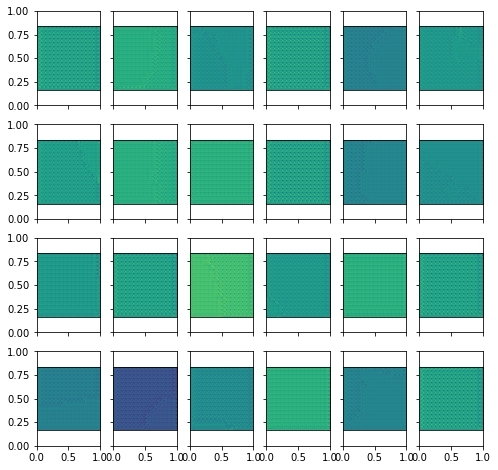

In [9]:
# test set 
"""
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap3_beta000001_segmented_Incremental.pth'))
model.eval()
model.to(device)
"""

#test_dataset = ImageDataset(root_dir='./data/kodac/', transform=transforms.Compose([RandomCrop(128), ToTensor()]))
#test_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/test', transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()]))
test_dataset = ImageDataset(depthmap_dir='C:/Users/Flora/autoencoder/test/dilated', 
                                mask_dir='C:/Users/Flora/autoencoder/test/mask',
                                segmentation_dir='C:/Users/Flora/autoencoder/test/segmentation_roipoly',
                                transform=transforms.Compose([RandomCrop((128, 128)), ToTensor()])
                                 )
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))
with torch.no_grad():            
    for i in range(len(test_dataset)):
        test_image = test_dataset[i][0].unsqueeze(0).to(device).float()
        test_mask = test_dataset[i][1].unsqueeze(0).to(device).float()
        test_seg = test_dataset[i][2].unsqueeze(0).to(device).float()
        #test_image = test_dataset[i].unsqueeze(0).to(device).float()
               
        if test_image.size(2)>test_image.size(3):
            test_image = test_image.permute(0, 1, 3, 2)
            test_seg = test_seg.permute(0, 1, 3, 2)

        #[reconstructed_image, vec_latent] = model(test_image, 1, True)
        [reconstructed_image, vec_latent, vec_latent_before_quantization] =  model(test_image, test_seg, 1, True)
        print("min vec latent : ", torch.min(vec_latent))
        print("max vec latent : ", torch.max(vec_latent))

        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
        plt.imshow(torch.squeeze(reconstructed_image.int().cpu()))

        """
        # We can set the number of bins with the `bins` kwarg
        bins_list = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        for k in range(96):
            # plot histograms
            fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
            ax.hist((vec_latent[:, k, :, :]).view(-1).cpu(), bins=bins_list)
            plt.savefig("D:\\autoencoder_data\\histograms\\depthmap\\" + "img" + str(i)+ "hist" + str(k) + ".png")
        """

In [ ]:
# save results
import cv2
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        reconstructed_image = model(test_image)
        reconstructed_depthmap = np.squeeze(reconstructed_image.cpu()).numpy()
        cv2.imwrite("D:\\autoencoder_data\\depthmaps2\\reconstructed\\beta_1\\" + "img" + str(i)+".png", reconstructed_depthmap.astype(np.uint16))
        #save_image(reconstructed_depthmap, "D:\\autoencoder_data\\depthmaps\\reconstructed\\beta_0001\\" + "img" + str(i)+".png", normalize=True)

In [ ]:
# compute PSNR for each image of the test set and its reconstruction

def write_data(filepath , tensor_data):
    batch, channel, h, w = tensor_data.size()
    matrix = tensor_data.cpu().numpy()
    file = open(filepath, "w")
    for image in range(batch):
        np.savetxt(file, matrix[image, :, :, :].reshape(channel*h, w), fmt ='%.0f')

    file.close()
    
def compute_entropy(tensor_data):
    min_val = tensor_data.min()
    max_val = tensor_data.max()
    nb_bins = max_val - min_val + 1
    hist = torch.histc(tensor_data, bins=nb_bins.int(), min=min_val, max=max_val)
    hist_prob = hist/hist.sum()
    hist_prob[hist_prob == 0] = 1
    entropy = -(hist_prob*torch.log2(hist_prob)).sum()
    return entropy
    
        
    
    
def psnr(original, compressed, max_pixel): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 


test_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/test', transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()]))
psnr_sum = 0.0
bit_rate_sum = 0.0
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, im_quantized] = model(test_image, 1, True)
        #write_data('.\\reconstructed_data\\kodac\\loss_distortion_and_bitrate\\beta_2\\latent_vect\\' + 'vec' + str(i) +'.txt', im_quantized)
        nb_symbols = im_quantized.size(0)*im_quantized.size(1)*im_quantized.size(2)*im_quantized.size(3)
        entropy = compute_entropy(im_quantized)
        nbpp = nb_symbols*entropy/float(test_image.size(0)*test_image.size(2)*test_image.size(3))
        psnr_sum+= psnr(test_image.cpu(), reconstructed_image.cpu(), 2**16-1.0)
        bit_rate_sum += nbpp
        print("entropy : ", entropy)
        print( "nb bits per pixel : ", nbpp)
        print("psnr : " , psnr(test_image.cpu(), reconstructed_image.cpu(), 2**16-1.0))
print( "mean nb bits per pixel : ", bit_rate_sum/len(test_dataset))
print("psnr mean : ", psnr_sum/len(test_dataset) )

In [ ]:
def compute_entropy(tensor_data):
    min_val = tensor_data.min()
    max_val = tensor_data.max()
    nb_bins = max_val - min_val + 1
    hist = torch.histc(tensor_data, bins=nb_bins.int(), min=min_val, max=max_val)
    hist_prob = hist/hist.sum()
    hist_prob[hist_prob == 0] = 1
    entropy = -(hist_prob*torch.log2(hist_prob)).sum()
    return entropy
       
    
    
def psnr(original, compressed, max_pixel): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 


# Load previous model
model_prev = LossyCompAutoencoder()
model_prev.load_state_dict(torch.load('./model_parameters/lossy_comp_params_with_rate_beta2_incremental_2.pth'))
model_prev.eval()
model_prev.to(device)


# And run test 
test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, im_quantized] = model_prev(test_image,1, True)
        nb_symbols = im_quantized.size(0)*im_quantized.size(1)*im_quantized.size(2)*im_quantized.size(3)
        entropy = compute_entropy(im_quantized)
        nbpp = nb_symbols*entropy/float(test_image.size(0)*test_image.size(1)*test_image.size(2)*test_image.size(3))
        print("nb_symbols : ", nb_symbols)
        print("entropy : ", entropy)
        print( "nb bits per pixel : ", nbpp)
        print("psnr : " , psnr(test_image.cpu(), reconstructed_image.cpu(), 255.0))
    
# And print figures
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))
with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        if test_image.size(2)<test_image.size(3):
            test_image = test_image.permute(0, 1, 3, 2)
        
        reconstructed_image = model_prev(test_image, 1,  False)
        ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(reconstructed_image.int().cpu()).permute(1, 2, 0))
        
# And save figures
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        
        reconstructed_image = np.squeeze(model_prev(test_image).cpu())
        print(reconstructed_image.type())
        save_image(reconstructed_image, ".\\reconstructed_data\\kodac\\loss_distortion_and_bitrate\\beta_2_incremental_bis\\" + "img" + str(i)+".png", normalize=True)

In [ ]:
"""
def entropy_rate(x_quantized, phi, var):
    u = torch.arange(-0.5, 0.5+0.01, 0.01).cuda()        
    gsm_sum = torch.zeros(len(u)).cuda()
    for i in range(len(u)):
        x = x_quantized + u[i]
        gsm_sum_i = sum_gsm(x, var, phi, 6)
        gsm_sum[i] = gsm_sum_i

    entropy = torch.trapz(gsm_sum, u)
    
    return entropy
"""

# Load incremental model
incremental_model = LossyCompAutoencoder()
incremental_model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_depthmap3_beta1_without_bitrate.pth'))
incremental_model.train()
incremental_model.to(device)

# train again the model starting form incremental-learned weights
    #define optimizer
optimizer = torch.optim.Adam(incremental_model.parameters(), lr=0.00001)

# define loss function
distortion = nn.MSELoss().cuda()


# define beta
beta = 1.0

#Epochs
n_epochs = 800


# Training the network
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
           
    #Training
    for i_batch, data in enumerate(dataloader):
        batch_images = data.to(device).float()
        [decoded_images, x_quantized, x_latent_before_quantization] = incremental_model(batch_images, 1, True, False)
        optimizer.zero_grad()
        #entropy = entropy_rate(x_quantized, incremental_model.phi, incremental_model.var)
        #print("entropy : ", entropy)
        dist = distortion(decoded_images, batch_images)
        #print("distortion : ", dist)
        #loss = beta * dist + entropy
        loss = beta*dist
        loss.backward()
        #print("conv1.weights grad: ", params[0].grad)
        #print(model.conv1.bias.grad)
        #print(model.conv1.weight.grad)
        optimizer.step()
        running_loss += loss.item()

    running_loss = running_loss/len(dataloader)
    print('running loss : {:.06f}'.format(running_loss), )
    

In [ ]:
from range_coder import RangeEncoder, RangeDecoder, prob_to_cum_freq
import os

# Load previous model
model = LossyCompAutoencoder()
model.load_state_dict(torch.load('./model_parameters/mean_bit_ppx/lossy_comp_params_with_rate_beta0005_incremental.pth'))
model.eval()
model.to(device)

nb_bits = 0.0
test_dataset = ImageDataset(root_dir='./data/kodac/', transform=ToTensor())
with torch.no_grad():  
    for i in range(len(test_dataset)):
        test_image = test_dataset[i].unsqueeze(0).to(device).float()
        [reconstructed_image, data_comp] = model(test_image, 1, True)
            # compute symbol probabilities
        min_val = data_comp.min()
        if min_val <0:
            data_comp -= min_val
            min_val = 0
        max_val = data_comp.max()
        nb_bins = max_val - min_val + 1
        hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
        prob = hist/hist.sum()
        #print("data comp : ", data_comp)
        #print(prob)
        
        """
        if len(torch.nonzero(prob)) != len(prob):
            zero_indices = ((prob == 0).nonzero())
            for j in reversed(range(0, len(zero_indices), 1)):
                data_comp[data_comp > int(zero_indices[j])+min_val] -=1
            min_val = data_comp.min()
            max_val = data_comp.max()
            nb_bins = max_val - min_val + 1
            hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
            prob = hist/hist.sum()
            print(min_val)
            print(max_val)
            print("data comp : ", data_comp)
            print(prob)
         """ 
            
            # convert probabilities to cumulative integer frequency table
        #cumFreq = prob_to_cum_freq(torch.clamp(prob, min=np.finfo(np.float32).eps).cpu(), resolution=128)
        cumFreq = prob_to_cum_freq(prob.cpu(), resolution=128)
        #print(cumFreq)
        
        # encode data
        filepath_to_write = "D:\\lossy_autoencoder\\latent_vect_encoded\\" + "img" + str(i) + ".bin"
        encoder = RangeEncoder(filepath_to_write)
        #print(torch.flatten(data_comp).cpu().tolist())
        encoder.encode(torch.flatten(data_comp.int()).cpu().tolist(), cumFreq)
        encoder.close()
        
        
        file_size = os.path.getsize(filepath_to_write)*8 #number of bits in the file
        print(file_size)
        nb_bits += file_size
        
    nb_bits_per_image = nb_bits/len(test_dataset)
    print(nb_bits_per_image)
    nb_bits_per_pixel = nb_bits_per_image/(512*768)
    print(nb_bits_per_pixel)
    
    
"""
    test_image = test_dataset[1].unsqueeze(0).to(device).float()
    [reconstructed_image, data_comp] = model(test_image, 1, True)
        # compute symbol probabilities
    min_val = data_comp.min()
    print(min_val)
    print(data_comp.max())
    if min_val <0:
        data_comp -= min_val
        min_val = 0
    max_val = data_comp.max()
    
    print(max_val)
    nb_bins = max_val - min_val + 1
    print(nb_bins)
    hist = torch.histc(data_comp, bins=nb_bins.int(), min=min_val, max=max_val)
    prob = hist/hist.sum()
    print(prob)
         # convert probabilities to cumulative integer frequency table
    cumFreq = prob_to_cum_freq(prob.cpu(), resolution=128)
    #print(cumFreq)

    print(torch.flatten(data_comp).cpu().tolist())
    
    
        # encode data
    filepath_to_write = "D:\\lossy_autoencoder\\latent_vect_encoded\\" + "img" + str(1) + ".bin"
    encoder = RangeEncoder(filepath_to_write)
    print(torch.flatten(data_comp).cpu().tolist())
    encoder.encode(torch.flatten(data_comp.int()).cpu().tolist(), cumFreq)
    encoder.close()   
""" 
    

In [ ]:
import cv2
from torchvision.utils import save_image

test_dataset = ImageDataset(root_dir='D:/autoencoder_data/depthmaps/test', transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()]))
#fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(8,8))

for i in range(len(test_dataset)):
    test_image = test_dataset[i].unsqueeze(0).float().cuda()

    #test_image_without_black_px = black_pixels_removal_by_dilatation(test_image, torch.ones(3, 5))
    test_image_without_black_px = black_pixels_removal_by_dilatation(test_image)
    cv2.imwrite("D:\\autoencoder_data\\depthmaps2\\dilated\\" + "img" + str(i)+".png", np.squeeze(test_image_without_black_px.cpu().numpy()).astype(np.uint16))
    #ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
    #plt.imshow(torch.squeeze(test_image_without_black_px).cpu())

"""    
i = 0
test_image = test_dataset[i].unsqueeze(0).float()

#test_image_without_black_px = black_pixels_removal_by_dilatation(test_image, torch.ones(3, 5))
test_image_without_black_px = black_pixels_removal_by_dilatation(test_image)
ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[])
plt.imshow(torch.squeeze(test_image_without_black_px))
"""

In [3]:
torch.cuda.empty_cache()